# Predict heart failure with Watson Machine Learning

![](https://www.cdc.gov/vitalsigns/heartdisease-stroke/images/graph4_980px.jpg)

This notebook contains steps and code to create a predictive model to predict heart failure and then deploy that model to Watson Machine Learning so it can be used in an application.

## Learning Goals

The learning goals of this notebook are:

* Load a CSV file into the Object Storage service linked to your Watson Studio
* Create an Apache Spark machine learning model
* Train and evaluate a model
* Persist a model in a Watson Machine Learning repository

## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

* Create a Watson Machine Learning service instance (a free plan is offered) and associate it with your project
* Upload heart failure data to the Object Store service that is part of Watson Studio

We'll be using a few libraries for this exercise:

1. [Watson Machine Learning Client](http://wml-api-pyclient.mybluemix.net/): Client library to work with the Watson Machine Learning service on IBM Cloud.
1. [Pixiedust](https://github.com/pixiedust/pixiedust): Python Helper library for Jupyter Notebooks
1. [ibmos2spark](https://github.com/ibm-watson-data-lab/ibmos2spark): Facilitates Data I/O between Spark and IBM Object Storage services

In [98]:
!pip install --upgrade ibmos2spark
!pip install --upgrade pixiedust


"""
    For Watson Studio Local, the WML modules are already present under a different name `dsx_ml`
"""
#!pip install --upgrade watson-machine-learning-client

Requirement already up-to-date: ibmos2spark in /opt/conda3/lib/python3.5/site-packages (1.0.1)
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: pixiedust in /opt/conda3/lib/python3.5/site-packages (1.1.17)
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


'\n    For Watson Studio Local, the WML modules are already present under a different name `dsx_ml`\n'

## 2. Load and explore data

In this section you will load the data as an Apache Spark DataFrame and perform a basic exploration. Load the data to the Spark DataFrame from your associated Object Storage instance.

> **IMPORTANT**: Follow the lab instructions to insert an Apache Spark DataFrame in the cell below.

> **IMPORTANT**: Ensure the DataFrame is named `df_data`.

> **IMPORTANT**: Add `.option('inferSchema','True')\` to the inserted code.

In [99]:
import os
from pyspark.sql import SQLContext
# Add asset from file system
df_data_1 = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/patientdataV6.csv', header='true', inferSchema = 'true')
df_data_1.show(5)

+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|CHOLESTEROL|BMI|HEARTFAILURE|AGE|SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|
+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|                 93|                22|        163| 25|           N| 49|  F|            N|             N|               110|
|                108|                22|        181| 24|           N| 32|  F|            N|             N|               192|
|                 86|                 0|        239| 20|           N| 60|  F|            N|             N|               121|
|                 80|                36|        164| 31|           Y| 45|  F|            Y|             N|               141|
|                 66|                36|        185| 23|           N| 39|  F|            N|             N|            

In [100]:
df_data = df_data_1

Explore the loaded data by using the following Apache® Spark DataFrame methods:

* `df_data.printSchema` to print the data schema
* `df_data.describe()` to print the top twenty records
* `df_data.count()` to count all records

In [101]:
df_data.printSchema()

root
 |-- AVGHEARTBEATSPERMIN: integer (nullable = true)
 |-- PALPITATIONSPERDAY: integer (nullable = true)
 |-- CHOLESTEROL: integer (nullable = true)
 |-- BMI: integer (nullable = true)
 |-- HEARTFAILURE: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- SEX: string (nullable = true)
 |-- FAMILYHISTORY: string (nullable = true)
 |-- SMOKERLAST5YRS: string (nullable = true)
 |-- EXERCISEMINPERWEEK: integer (nullable = true)



As you can see, the data contains ten  fields. The  HEARTFAILURE field is the one we would like to predict (label).

In [102]:
df_data.show()

+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|CHOLESTEROL|BMI|HEARTFAILURE|AGE|SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|
+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+
|                 93|                22|        163| 25|           N| 49|  F|            N|             N|               110|
|                108|                22|        181| 24|           N| 32|  F|            N|             N|               192|
|                 86|                 0|        239| 20|           N| 60|  F|            N|             N|               121|
|                 80|                36|        164| 31|           Y| 45|  F|            Y|             N|               141|
|                 66|                36|        185| 23|           N| 39|  F|            N|             N|            

In [103]:
df_data.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------+------------------+-----+-------------+--------------+------------------+
|summary|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|       CHOLESTEROL|               BMI|HEARTFAILURE|               AGE|  SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|
+-------+-------------------+------------------+------------------+------------------+------------+------------------+-----+-------------+--------------+------------------+
|  count|              10800|             10800|             10800|             10800|       10800|             10800|10800|        10800|         10800|             10800|
|   mean|  87.11509259259259|20.423148148148147|195.08027777777778| 26.35972222222222|        null|49.965185185185184| null|         null|          null|119.72953703703703|
| stddev| 19.744375148984474|12.165320351622993|26.136731865042325|3.8201472810942136|        null|13.079280962015586| null|         nu

In [104]:
df_data.count()

10800

As you can see, the data set contains 10800 records.

## 3. Interactive Visualizations w/PixieDust

In [105]:
import pixiedust

### Simple visualization using bar charts

With PixieDust's `display()` method you can visually explore the loaded data using built-in charts, such as, bar charts, line charts, scatter plots, or maps.
To explore a data set: choose the desired chart type from the drop down, configure chart options, configure display options.

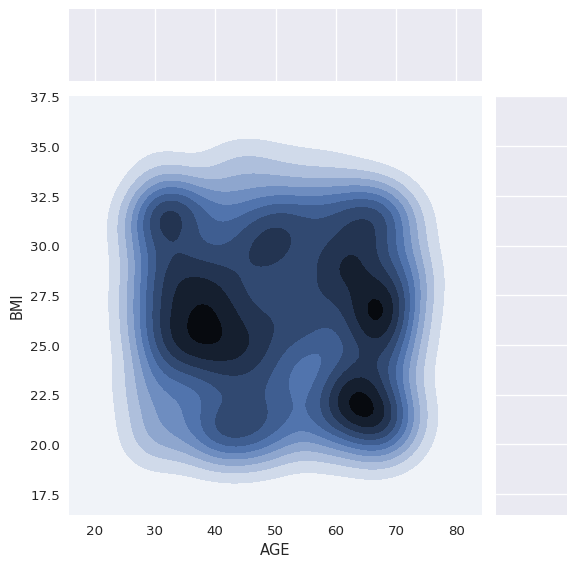

In [106]:
display(df_data)

## 4. Create a Spark machine learning model

In this section you will learn how to prepare data, create and train a Spark machine learning model.

### 4.1 Prepare data

In this subsection you will split your data into: train and test data sets.

In [107]:
split_data = df_data.randomSplit([0.8, 0.20], 24)
train_data = split_data[0]
test_data = split_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 8637
Number of testing records : 2163


As you can see our data has been successfully split into two data sets:

* The train data set, which is the largest group, is used for training.
* The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 4.2 Create pipeline and train a model

In this section you will create a Spark machine learning pipeline and then train the model. In the first step you need to import the Spark machine learning packages that will be needed in the subsequent steps. A sequence of data processing is called a _data pipeline_. Each step in the pipeline processes the data and passes the result to the next step in the pipeline, this allows you to transform and fit your model with the raw input data.

In [108]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In the following step, convert all the string fields to numeric ones by using the StringIndexer transformer.

In [109]:
stringIndexer_label = StringIndexer(inputCol="HEARTFAILURE", outputCol="label").fit(df_data)
stringIndexer_sex = StringIndexer(inputCol="SEX", outputCol="SEX_IX")
stringIndexer_famhist = StringIndexer(inputCol="FAMILYHISTORY", outputCol="FAMILYHISTORY_IX")
stringIndexer_smoker = StringIndexer(inputCol="SMOKERLAST5YRS", outputCol="SMOKERLAST5YRS_IX")


In the following step, create a feature vector by combining all features together.

In [110]:
vectorAssembler_features = VectorAssembler(inputCols=["AVGHEARTBEATSPERMIN","PALPITATIONSPERDAY","CHOLESTEROL","BMI","AGE","SEX_IX","FAMILYHISTORY_IX","SMOKERLAST5YRS_IX","EXERCISEMINPERWEEK"], outputCol="features")

Next, define estimators you want to use for classification. Random Forest is used in the following example.

In [111]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

Finally, indexed labels back to original labels.

In [112]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=stringIndexer_label.labels)

In [113]:
transform_df_pipeline = Pipeline(stages=[stringIndexer_label, stringIndexer_sex, stringIndexer_famhist, stringIndexer_smoker, vectorAssembler_features])
transformed_df = transform_df_pipeline.fit(df_data).transform(df_data)
transformed_df.show()

+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+-----+------+----------------+-----------------+--------------------+
|AVGHEARTBEATSPERMIN|PALPITATIONSPERDAY|CHOLESTEROL|BMI|HEARTFAILURE|AGE|SEX|FAMILYHISTORY|SMOKERLAST5YRS|EXERCISEMINPERWEEK|label|SEX_IX|FAMILYHISTORY_IX|SMOKERLAST5YRS_IX|            features|
+-------------------+------------------+-----------+---+------------+---+---+-------------+--------------+------------------+-----+------+----------------+-----------------+--------------------+
|                 93|                22|        163| 25|           N| 49|  F|            N|             N|               110|  0.0|   1.0|             0.0|              0.0|[93.0,22.0,163.0,...|
|                108|                22|        181| 24|           N| 32|  F|            N|             N|               192|  0.0|   1.0|             0.0|              0.0|[108.0,22.0,181.0...|
|                 86|    

Let's build the pipeline now. A pipeline consists of transformers and an estimator.

In [114]:
pipeline_rf = Pipeline(stages=[stringIndexer_label, stringIndexer_sex, stringIndexer_famhist, stringIndexer_smoker, vectorAssembler_features, rf, labelConverter])

Now, you can train your Random Forest model by using the previously defined **pipeline** and **training data**.

In [115]:
model_rf = pipeline_rf.fit(train_data)

You can check your **model accuracy** now. To evaluate the model, use **test data**.

In [116]:
predictions = model_rf.transform(test_data)
evaluatorRF = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.867776
Test Error = 0.132224


You can tune your model now to achieve better accuracy. For simplicity of this example tuning section is omitted.

## 5. Persist model

In this section you will learn how to store your pipeline and model in Watson Machine Learning repository by using Python client libraries.
First, you must import client libraries.

> **IMPORTANT**: Update the `wml_credentials` variable below. Copy and paste the entire credential dictionary, which can be found on the _Service Credentials_ tab of the Watson Machine Learning service instance created on the IBM Cloud.

---

Cell changed for WML

In [117]:
"""
wml_credentials = {
  "apikey": "xxxxxxxxxxx",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/e36fbbaf35594080bd3ead332362abdf:3814e7da-e3c4-440b-ba26-52a15fd5a1de::",
  "iam_apikey_name": "auto-generated-apikey-23c32db1-82c6-4e6e-bb32-000459a6501a",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/e36fbbaf35594080bd3ead332362abdf::serviceid:ServiceId-a2c0f708-a29a-40a8-961e-62d5dabac943",
  "instance_id": "xxxxxxxxxxx",
  "password": "",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": ""
}

print(wml_credentials)
"""

print("No credentials needed in WML")

No credentials needed in WML


In [118]:
from dsx_ml.ml import save

> **TIP**: Update the cell below with your name, email, and name you wish to give to your model.

In [119]:
"""model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "IBM", 
               client.repository.ModelMetaNames.NAME: "Heart Failure Prediction Model"}
published_model = client.repository.store_model(model=model_rf, pipeline=pipeline_rf, meta_props=model_props, training_data=train_data)
"""

saved_model_output = save(model=model_rf,name="heartfailure", description="Heart Failure Prediction Model V2", test_data=train_data, algorithm_type="Regression")


## 5.1 Save pipeline and model

In this subsection you will learn how to save pipeline and model artifacts to your Watson Machine Learning instance.

In [120]:
"""import json
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))
"""

saved_model_output

{'path': '/user-home/999/DSX_Projects/Heart Rate Model Demo/models/heartfailure/2',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python35/spark-2.2/Heart%20Rate%20Model%20Demo/heartfailure/2'}


## 5.2 Load model to verify that it was saved correctly

You can load your model to make sure that it was saved correctly.

In [121]:
import os
import requests

header_online = {'Content-Type': 'application/json', 'Authorization': os.environ['DSX_TOKEN']}

print(saved_model_output['scoring_endpoint'])

https://dsxl-api/v3/project/score/Python35/spark-2.2/Heart%20Rate%20Model%20Demo/heartfailure/2


Call model against test data to verify that it has been loaded correctly. Examine top 3 results

## <font color=green>Congratulations</font>, you've sucessfully created a predictive model and saved it in the Watson Machine Learning service. 

You can now switch to the Watson Machine Learning console to deploy the model and then test it in application, or continue within the notebook to deploy the model using the APIs.

***

## 6.0 Accessing Watson ML Models and Deployments through API

Instead of jumping from your notebook into a web browser, manage your model and delopment through a set of APIs

## 6.1 Invoke prediction model deployment

WSL and Watson Studio Cloud uses slightly different API call structure.

WS Cloud:
```
scoring_payload = { "fields":["AVGHEARTBEATSPERMIN","PALPITATIONSPERDAY","CHOLESTEROL","BMI","AGE","SEX","FAMILYHISTORY","SMOKERLAST5YRS","EXERCISEMINPERWEEK"],"values":[[100,85,242,24,44,"F","Y","Y",125]]}
```

WS Local:

```
scoring_payload = {'AGE': 44,
 'AVGHEARTBEATSPERMIN': 100,
 'BMI': 24,
 'CHOLESTEROL': 242,
 'EXERCISEMINPERWEEK': 125,
 'FAMILYHISTORY': 'Y',
 'PALPITATIONSPERDAY': 85,
 'SEX': 'F',
 'SMOKERLAST5YRS': 'Y'}
```

In [125]:
K = ["AVGHEARTBEATSPERMIN","PALPITATIONSPERDAY","CHOLESTEROL","BMI","AGE","SEX","FAMILYHISTORY","SMOKERLAST5YRS","EXERCISEMINPERWEEK"]
V = [100,85,242,24,44,"F","Y","Y",125]

payload_dict = {}
for k,v in zip(K,V):
    payload_dict[k] = v
    
payload_dict

{'AGE': 44,
 'AVGHEARTBEATSPERMIN': 100,
 'BMI': 24,
 'CHOLESTEROL': 242,
 'EXERCISEMINPERWEEK': 125,
 'FAMILYHISTORY': 'Y',
 'PALPITATIONSPERDAY': 85,
 'SEX': 'F',
 'SMOKERLAST5YRS': 'Y'}

In [126]:
payload = [payload_dict]
scoring_response = requests.post(saved_model_output['scoring_endpoint'], json=payload, headers=header_online, verify=False)

print(scoring_response.content)

b'{"success":true,"description":"Success","object":{"error":"","output":{"classes":["N","Y"],"predictions":["Y"],"probabilities":[[0.33825216736845,0.6617478326315501]]},"returnCode":"0"}}'


In [127]:
response_dict = json.loads( scoring_response.content.decode('utf-8') )

### Narrow down prediction results to just the prediction

In [128]:
print('Is a 44 year old female that smokes with a low BMI at risk of Heart Failure?: {}'.format(response_dict["object"]["output"]["predictions"]))

Is a 44 year old female that smokes with a low BMI at risk of Heart Failure?: ['Y']
